# Haar Sampler

In [2]:
import numpy as np
def haar_unitary(n, rng=None):
    rng = np.random.default_rng(rng)
    X = (rng.standard_normal((n,n)) + 1j*rng.standard_normal((n,n)))/np.sqrt(2)
    Q, R = np.linalg.qr(X)
    # print(R)
    d = np.diag(R)
    D = d / np.abs(d)
    return Q * D
def haar_su(n, rng=None):
    U = haar_unitary(n, rng)
    phi = np.angle(np.linalg.det(U))/n
    return U * np.exp(-1j*phi)

print(haar_su(4,2))

[[-0.05709669+0.18978766j -0.05300748-0.54632977j  0.35786636+0.42499958j
  -0.22491192-0.54786518j]
 [ 0.33155101+0.59626733j  0.02737921+0.12964545j  0.35519332+0.33091098j
   0.37542832+0.37466097j]
 [ 0.28161873-0.22471055j -0.57925066+0.38583278j -0.26303544+0.50691885j
   0.05637872-0.23762339j]
 [ 0.25643869-0.54744413j  0.11580723-0.42819021j  0.03425158+0.358211j
  -0.10904101+0.5444334j ]]


# Original Decomposer

In [16]:
import numpy as np
from numpy.linalg import norm
from math import pi
import matplotlib.pyplot as plt
import itertools
def detect_adjacent_same_couplings(rotation_mats, tol=1e-8):
    def find_coupled_level(U):
        for j in range(1, U.shape[0]):
            if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                return j
        return None
    matches = []
    for U1, U2 in zip(rotation_mats[:-1], rotation_mats[1:]):
        j1 = find_coupled_level(U1)
        j2 = find_coupled_level(U2)
        matches.append(int(j1 == j2 and j1 is not None))
    return matches

def compress_rotations(rotation_mats, tol=1e-8):
    i = 0
    optimized = []
    I = np.eye(rotation_mats[0].shape[0], dtype=complex)
    while i < len(rotation_mats):
        if i + 1 < len(rotation_mats):
            U1 = rotation_mats[i]
            U2 = rotation_mats[i+1]
            j1 = next((j for j in range(1, U1.shape[0]) if np.abs(U1[0, j]) > tol or np.abs(U1[j, 0]) > tol), None)
            j2 = next((j for j in range(1, U2.shape[0]) if np.abs(U2[0, j]) > tol or np.abs(U2[j, 0]) > tol), None)
            if j1 == j2 and j1 is not None:
                combined = U2 @ U1
                if norm(combined - I) < tol:
                    i += 2
                    continue
                else:
                    optimized.append(combined)
                    i += 2
                    continue
        optimized.append(rotation_mats[i])
        i += 1
    return optimized

def inverse_single_pulse(U, tol=1e-8):
    U = np.asarray(U, dtype=complex)
    dim = U.shape[0]
    cand = [(p, q) for p in range(dim) for q in range(p+1, dim) if abs(U[p, q]) > tol or abs(U[q, p]) > tol]
    if len(cand) != 1:
        return (0, 0), 0.0, 0.0
    i, j = cand[0]
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim, dtype=complex)[mask]) > tol:
        raise ValueError("Extra couplings detected")
    a = U[i, i]
    b = U[i, j]
    if not (np.allclose(U[j, j], np.conjugate(a), atol=tol) and np.allclose(U[j, i], -np.conjugate(b), atol=tol)):
        raise ValueError("Not a single two-level unitary of the expected form")
    c = a
    s = b
    c_abs = np.clip(np.abs(c), 0.0, 1.0)
    s_abs = np.clip(np.abs(s), 0.0, 1.0)
    if c_abs == 0.0 and s_abs == 0.0:
        return (i, j), 0.0, 0.0
    theta = 2.0 * np.arctan2(s_abs, c_abs)
    phi = (np.angle(s) - np.angle(c)) % (2 * np.pi)
    return (i, j), float(theta / np.pi), float(phi)

def two_level_left(m, p, q, c, s):
    U = np.eye(m, dtype=complex)
    if p == q:
        return U
    U[p, p] = c
    U[p, q] = s
    U[q, p] = -np.conjugate(s)
    U[q, q] = np.conjugate(c)
    return U

def swap_like_left(m, p, q):
    return two_level_left(m, p, q, 0.0 + 0j, 1.0 + 0j)

def star_zero_pair(m, j, a, b, tol=1e-12):
    r = np.sqrt(np.abs(a) ** 2 + np.abs(b) ** 2)
    if r < tol:
        return np.eye(m, dtype=complex)
    c = np.conjugate(a) / r
    s = np.conjugate(b) / r
    return two_level_left(m, 0, j, c, s)

def star_qr_decomposition(order, U, tol=1e-10):
    m = U.shape[0]
    rotations_info = []
    rotation_mats = []
    V = U.astype(complex).copy()
    col = 0
    count = 0
    for i in order[::-1]:
        a = V[0, col]
        b = V[i, col]
        if np.abs(b) < tol:
            continue
        G = star_zero_pair(m, i, a, b, tol)
        V = G @ V
        rotations_info.append(("rotate", i, None, col))
        rotation_mats.append(G)
    for col in order:
        G_swap = swap_like_left(m, 0, col)
        V = G_swap @ V
        rotations_info.append(("swap", col, None, col))
        rotation_mats.append(G_swap)
        count += 1
        if count % 2 == 0:
            seq = order[count:][::-1]
        else:
            seq = order[count:]
        for i in seq:
            a = V[0, col]
            b = V[i, col]
            if np.abs(b) < tol:
                continue
            G = star_zero_pair(m, i, a, b, tol)
            V = G @ V
            rotations_info.append(("rotate", i, None, col))
            rotation_mats.append(G)
        V = G_swap @ V
        rotations_info.append(("swap_back", col, None, col))
        rotation_mats.append(G_swap)
    return rotations_info, V, rotation_mats


dim = 4

def haar_unitary(n, rng=None):
    rng = np.random.default_rng(rng)
    X = (rng.standard_normal((n,n)) + 1j*rng.standard_normal((n,n)))/np.sqrt(2)
    Q, R = np.linalg.qr(X)
    # print(R)
    d = np.diag(R)
    D = d / np.abs(d)
    return Q * D
def haar_su(n, rng=None):
    U = haar_unitary(n, rng)
    phi = np.angle(np.linalg.det(U))/n
    return U * np.exp(-1j*phi)

H2 = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
U = np.kron(H2, H2)
U  = haar_su(dim, 2)
# QFT = np.array([[1,1,1,1],[1,1j,-1,-1j],[1,-1,1,-1],[1,-1j,-1,1j]], dtype=complex)/2
# U = QFT
my_list = [2,1,3]
permutations = list(itertools.permutations(my_list))
# permutations = [my_list]
list_of_lens = []
for order in permutations:
    rotations_info, V_triangular, rotation_mats = star_qr_decomposition(order, U)
    # print(rotations_info)
    compressed = compress_rotations(rotation_mats)
    couplings = []
    fractions = []
    phases = []
    for r in compressed:
        coupling, f, phi = inverse_single_pulse(r)
        couplings.append(coupling)
        fractions.append(f)
        phases.append(phi/np.pi)
        # print(r)
    U_reconstructed = -1*np.eye(dim, dtype=complex)
    for G in reversed(compressed[:]):
        print(np.round(G,3))
        U_reconstructed = G.conj().T @ U_reconstructed
    print("U_reconstructed: \n",np.round(U_reconstructed,3))
    print("Original U: \n",np.round(U,3))
    print("Difference U - U_rec: \n",np.round(U - U_reconstructed,3))
    # plt.imshow(np.real(U_reconstructed), cmap='viridis', interpolation='nearest')
    # plt.show()
    # if len(couplings) <= 40:
    print('____________________________This works_____________________________________',len(couplings))
    print('couplings = ',couplings)
    print('fractions = ', fractions)
    print('phases = ', phases)
    print('||U - U_rec|| =', float(norm(U - U_reconstructed)))
                                                                                                          


[[-1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]
[[ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.-0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]
[[ 0.527-0.07j   0.   +0.j     0.   +0.j     0.784-0.319j]
 [ 0.   +0.j     1.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     1.   +0.j     0.   +0.j   ]
 [-0.784-0.319j  0.   +0.j     0.   +0.j     0.527+0.07j ]]
[[ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.-0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]
[[ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  0.-0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]
[[ 0.776-0.j     0.   +0.j     0.   +0.j    -0.62 -0.115j]
 [ 0.   +0.j     1.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     1.   +0.j     0.   +0.j   ]
 [ 0.62 -0.115j  0.   

# TAQR + permutation optimization

In [81]:
import numpy as np
from numpy.linalg import norm
from collections import deque
import math
import itertools

def two_level_left(m, p, q, c, s):
    U = np.eye(m, dtype=complex)
    if p == q:
        return U
    U[p, p] = c
    U[p, q] = s
    U[q, p] = -np.conjugate(s)
    U[q, q] = np.conjugate(c)
    return U

def zero_pair(m, p, q, a, b, tol=1e-12):
    r = np.sqrt(np.abs(a) ** 2 + np.abs(b) ** 2)
    if r < tol:
        return np.eye(m, dtype=complex)
    c = np.conjugate(a) / r
    s = np.conjugate(b) / r
    return two_level_left(m, p, q, c, s)

def bfs(adj, start, active):
    dist = {v: math.inf for v in active}
    parent = {v: None for v in active}
    dist[start] = 0
    dq = deque([start])
    while dq:
        v = dq.popleft()
        for w in adj[v]:
            if w not in active:
                continue
            if dist[w] is math.inf:
                dist[w] = dist[v] + 1
                parent[w] = v
                dq.append(w)
    return dist, parent

def is_connected(adj, active):
    active = set(active)
    if not active:
        return True
    start = next(iter(active))
    dist, _ = bfs(adj, start, active)
    return all(dist[v] is not math.inf for v in active)

def is_non_articulation(adj, active, v):
    active = set(active)
    if v not in active:
        return False
    remaining = active - {v}
    return is_connected(adj, remaining)

def build_taqr_scheme(adj):
    n = len(adj)
    active = set(range(n))
    scheme = []
    while len(active) > 1:
        candidates = [v for v in active if is_non_articulation(adj, active, v)]
        if not candidates:
            raise RuntimeError("No non-articulation vertex found")
        r = max(candidates)
        dist, parent = bfs(adj, r, active)
        L = max(dist[v] for v in active if dist[v] is not math.inf)
        pairs = []
        for level in range(L, 0, -1):
            layer = [v for v in active if dist[v] == level]
            for z in sorted(layer):
                p = parent[z]
                if p is None:
                    continue
                pairs.append((z, p))
        scheme.append((r, pairs))
        active.remove(r)
    remaining = next(iter(active))
    scheme.append((remaining, []))
    return scheme

def build_star_adj(dim, center=0):
    adj = {i: set() for i in range(dim)}
    for j in range(dim):
        if j == center:
            continue
        adj[center].add(j)
        adj[j].add(center)
    return adj

def taqr_eliminate(U, scheme, tol=1e-10):
    U = np.array(U, dtype=complex)
    d = U.shape[0]
    V = U.copy()
    rotation_mats = []
    for col, pairs in scheme:
        for z, p in pairs:
            b = V[z, col]
            if abs(b) < tol:
                continue
            a = V[p, col]
            G = zero_pair(d, p, z, a, b, tol)
            V = G @ V
            rotation_mats.append(G)
    return rotation_mats, V

def compute_phase_gate_from_V(V):
    diag = np.diag(V)
    P = np.diag(np.exp(-1j * np.angle(diag)))
    return P

def inverse_single_pulse(U, tol=1e-8):
    U = np.asarray(U, dtype=complex)
    dim = U.shape[0]
    cand = []
    for p in range(dim):
        for q in range(p + 1, dim):
            if abs(U[p, q]) > tol or abs(U[q, p]) > tol:
                cand.append((p, q))
    if len(cand) != 1:
        return (0, 0), 0.0, 0.0
    i, j = cand[0]
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim, dtype=complex)[mask]) > tol:
        raise ValueError("Extra couplings detected")
    a = U[i, i]
    b = U[i, j]
    if not (np.allclose(U[j, j], np.conjugate(a), atol=tol) and np.allclose(U[j, i], -np.conjugate(b), atol=tol)):
        raise ValueError("Not a single two-level unitary of the expected form")
    c = a
    s = b
    c_abs = np.clip(np.abs(c), 0.0, 1.0)
    s_abs = np.clip(np.abs(s), 0.0, 1.0)
    if c_abs == 0.0 and s_abs == 0.0:
        return (i, j), 0.0, 0.0
    theta = 2.0 * np.arctan2(s_abs, c_abs)
    phi = (np.angle(s) - np.angle(c)) % (2 * np.pi)
    return (i, j), float(theta / np.pi), float(phi)

def haar_unitary(n, rng=None):
    rng = np.random.default_rng(rng)
    X = (rng.standard_normal((n, n)) + 1j * rng.standard_normal((n, n))) / np.sqrt(2)
    Q, R = np.linalg.qr(X)
    d = np.diag(R)
    D = d / np.abs(d)
    return Q * D

def haar_su(n, rng=None):
    U = haar_unitary(n, rng)
    phi = np.angle(np.linalg.det(U)) / n
    return U * np.exp(-1j * phi)

def scheme_permutations(scheme):
    pair_lists = [pairs for (_, pairs) in scheme]
    perms_per_col = [list(itertools.permutations(pl)) if len(pl) > 1 else [pl] for pl in pair_lists]
    idx_lists = [list(range(len(pl))) for pl in perms_per_col]
    for combo in itertools.product(*idx_lists):
        new_scheme = []
        for (col, _), idx, perms in zip(scheme, combo, perms_per_col):
            new_scheme.append((col, list(perms[idx])))
        yield new_scheme

def decompose_and_reconstruct(U, scheme, tol=1e-10):
    rotation_mats, V = taqr_eliminate(U, scheme, tol)
    P = compute_phase_gate_from_V(V)
    U_rec = P.conj().T
    for G in reversed(rotation_mats):
        U_rec = G.conj().T @ U_rec
    diff = norm(U - U_rec)
    return rotation_mats, P, U_rec, diff

def print_sequence(rotation_mats, P):
    for k, G in enumerate(rotation_mats):
        (i, j), frac, phi = inverse_single_pulse(G)
        print(f"{k:2d}: coupling ({i},{j}), theta={frac:.6f}, phi={phi/np.pi:.6f}")
    phases = np.angle(np.diag(P))
    print("Diagonal phases (per level, /pi):", phases / np.pi)

# def demo():
#     dim = 4
#     adj = build_star_adj(dim, center=0)
#     scheme = build_taqr_scheme(adj)
#     print("Base TAQR scheme:")
#     print(scheme)
#     U = haar_su(dim, rng=2)
#     QFT = np.array([[1,1,1,1],[1,1j,-1,-1j],[1,-1,1,-1],[1,-1j,-1,1j]], dtype=complex)/2
#     Hadamard = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
#     # U = np.kron(Hadamard, Hadamard)
#     # U = np.kron(U, Hadamard) 
#     U = QFT
#     print("Original U:")
#     print(np.round(U, 3))
#     base_rots, base_P, base_Urec, base_diff = decompose_and_reconstruct(U, scheme)
#     print("\nBase scheme reconstruction:")
#     print("Reconstructed U:")
#     print(np.round(base_Urec, 3))
#     print("||U - U_rec|| =", base_diff)
#     print("Number of rotations:", len(base_rots))
#     print("Base sequence:")
#     print_sequence(base_rots, base_P)
#     print("\nIterating over permutations of couplings inside each column...")
#     valid_id = 0
#     for idx, sch in enumerate(scheme_permutations(scheme)):
#         rots, P, Urec, diff = decompose_and_reconstruct(U, sch)
#         if diff < 1e-8:
#             print("\nValid permutation id:", valid_id)
#             valid_id += 1
#             print("Scheme:", sch)
#             print("||U - U_rec|| =", diff)
#             print("Number of rotations:", len(rots))
#             print("Sequence:")
#             print_sequence(rots, P)

def demo_perm(dim = 4, rng = 2):
    adj = build_star_adj(dim, center=0)
    scheme = build_taqr_scheme(adj)
    # print("Base TAQR scheme:")
    # print(scheme)
    U = haar_su(dim, rng)
    # QFT = np.array([[1,1,1,1],[1,1j,-1,-1j],[1,-1,1,-1],[1,-1j,-1,1j]], dtype=complex)/2
    # Hadamard = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
    # U = np.kron(Hadamard, Hadamard)
    # U = np.kron(U, Hadamard) 
    # U = QFT
    # print("Original U:")
    # print(np.round(U, 3))
    base_rots, base_P, base_Urec, base_diff = decompose_and_reconstruct(U, scheme)
    # print("\nBase scheme reconstruction:")
    # print("Reconstructed U:")
    # print(np.round(base_Urec, 3))
    # print("||U - U_rec|| =", base_diff)
    # print("Number of rotations:", len(base_rots))
    # print("Base sequence:")
    # print_sequence(base_rots, base_P)

    # print("\nSearching permutations for best scheme...")
    best_scheme = None
    best_rots = None
    best_P = None
    best_diff = None
    best_num = None
    best_theta_sum = None

    for sch in scheme_permutations(scheme):
        rots, P, Urec, diff = decompose_and_reconstruct(U, sch)
        if diff >= 1e-8:
            continue
        num = len(rots)
        theta_sum = 0.0
        for G in rots:
            (_, _), frac, _ = inverse_single_pulse(G)
            theta_sum += frac
        if best_scheme is None:
            best_scheme = sch
            best_rots = rots
            best_P = P
            best_diff = diff
            best_num = num
            best_theta_sum = theta_sum
        else:
            if num < best_num or (num == best_num and theta_sum < best_theta_sum):
                best_scheme = sch
                best_rots = rots
                best_P = P
                best_diff = diff
                best_num = num
                best_theta_sum = theta_sum

    # if best_scheme is not None:
        # print("\nBest scheme:")
        # print("Scheme:", best_scheme)
        # print("||U - U_rec|| =", best_diff)
        # print("Number of rotations:", best_num)
        # print("Sum theta/pi:", best_theta_sum)
        # print("Best sequence:")
        # print_sequence(best_rots, best_P)
    if best_scheme is None:
        print("No valid permutation found.")
    return best_theta_sum


print(demo_perm(4,2))

3.371660427659645


# TAQR + permutation optimization + virtual X

In [48]:
import numpy as np
from numpy.linalg import norm
from collections import deque
import math
import itertools

def two_level_left(m, p, q, c, s):
    U = np.eye(m, dtype=complex)
    if p == q:
        return U
    U[p, p] = c
    U[p, q] = s
    U[q, p] = -np.conjugate(s)
    U[q, q] = np.conjugate(c)
    return U

def zero_pair(m, p, q, a, b, tol=1e-12):
    r = np.sqrt(np.abs(a) ** 2 + np.abs(b) ** 2)
    if r < tol:
        return np.eye(m, dtype=complex)
    c = np.conjugate(a) / r
    s = np.conjugate(b) / r
    return two_level_left(m, p, q, c, s)

def bfs(adj, start, active):
    dist = {v: math.inf for v in active}
    parent = {v: None for v in active}
    dist[start] = 0
    dq = deque([start])
    while dq:
        v = dq.popleft()
        for w in adj[v]:
            if w not in active:
                continue
            if dist[w] is math.inf:
                dist[w] = dist[v] + 1
                parent[w] = v
                dq.append(w)
    return dist, parent

def is_connected(adj, active):
    active = set(active)
    if not active:
        return True
    start = next(iter(active))
    dist, _ = bfs(adj, start, active)
    return all(dist[v] is not math.inf for v in active)

def is_non_articulation(adj, active, v):
    active = set(active)
    if v not in active:
        return False
    remaining = active - {v}
    return is_connected(adj, remaining)

def build_taqr_scheme(adj):
    n = len(adj)
    active = set(range(n))
    scheme = []
    while len(active) > 1:
        candidates = [v for v in active if is_non_articulation(adj, active, v)]
        if not candidates:
            raise RuntimeError("No non-articulation vertex found")
        r = max(candidates)
        dist, parent = bfs(adj, r, active)
        L = max(dist[v] for v in active if dist[v] is not math.inf)
        pairs = []
        for level in range(L, 0, -1):
            layer = [v for v in active if dist[v] == level]
            for z in sorted(layer):
                p = parent[z]
                if p is None:
                    continue
                pairs.append((z, p))
        scheme.append((r, pairs))
        active.remove(r)
    remaining = next(iter(active))
    scheme.append((remaining, []))
    return scheme

def build_star_adj(dim, center=0):
    adj = {i: set() for i in range(dim)}
    for j in range(dim):
        if j == center:
            continue
        adj[center].add(j)
        adj[j].add(center)
    return adj

def taqr_eliminate(U, scheme, tol=1e-10):
    U = np.array(U, dtype=complex)
    d = U.shape[0]
    V = U.copy()
    rotation_mats = []
    for col, pairs in scheme:
        for z, p in pairs:
            b = V[z, col]
            if abs(b) < tol:
                continue
            a = V[p, col]
            G = zero_pair(d, p, z, a, b, tol)
            V = G @ V
            rotation_mats.append(G)
    return rotation_mats, V

def apply_rotations(U, rotation_mats):
    V = U.copy()
    for G in rotation_mats:
        V = G @ V
    return V

def compute_phase_gate(U, rotation_mats, tol=1e-10):
    V = apply_rotations(U, rotation_mats)
    diag = np.diag(V)
    P = np.diag(np.exp(-1j * np.angle(diag)))
    V2 = P @ V
    return P, V2

def inverse_single_pulse(U, tol=1e-8):
    U = np.asarray(U, dtype=complex)
    dim = U.shape[0]
    cand = []
    for p in range(dim):
        for q in range(p + 1, dim):
            if abs(U[p, q]) > tol or abs(U[q, p]) > tol:
                cand.append((p, q))
    if len(cand) != 1:
        return (0, 0), 0.0, 0.0
    i, j = cand[0]
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim, dtype=complex)[mask]) > tol:
        raise ValueError("Extra couplings detected")
    a = U[i, i]
    b = U[i, j]
    if not (np.allclose(U[j, j], np.conjugate(a), atol=tol) and np.allclose(U[j, i], -np.conjugate(b), atol=tol)):
        raise ValueError("Not a single two-level unitary of the expected form")
    c = a
    s = b
    c_abs = np.clip(np.abs(c), 0.0, 1.0)
    s_abs = np.clip(np.abs(s), 0.0, 1.0)
    if c_abs == 0.0 and s_abs == 0.0:
        return (i, j), 0.0, 0.0
    theta = 2.0 * np.arctan2(s_abs, c_abs)
    phi = (np.angle(s) - np.angle(c)) % (2 * np.pi)
    return (i, j), float(theta / np.pi), float(phi)

def compress_rotations(rotation_mats, tol=1e-8):
    if not rotation_mats:
        return []
    optimized = []
    n = rotation_mats[0].shape[0]
    I = np.eye(n, dtype=complex)
    i = 0
    while i < len(rotation_mats):
        if i + 1 < len(rotation_mats):
            (p1, q1), _, _ = inverse_single_pulse(rotation_mats[i], tol)
            (p2, q2), _, _ = inverse_single_pulse(rotation_mats[i+1], tol)
            if (p1, q1) != (0, 0) and {p1, q1} == {p2, q2}:
                combined = rotation_mats[i+1] @ rotation_mats[i]
                if norm(combined - I) < tol:
                    i += 2
                    continue
                optimized.append(combined)
                i += 2
                continue
        optimized.append(rotation_mats[i])
        i += 1
    return optimized

def haar_unitary(n, rng=None):
    rng = np.random.default_rng(rng)
    X = (rng.standard_normal((n, n)) + 1j * rng.standard_normal((n, n))) / np.sqrt(2)
    Q, R = np.linalg.qr(X)
    d = np.diag(R)
    D = d / np.abs(d)
    return Q * D

def haar_su(n, rng=None):
    U = haar_unitary(n, rng)
    phi = np.angle(np.linalg.det(U)) / n
    return U * np.exp(-1j * phi)

def reconstruct_from_sequence(rotation_mats, P):
    dim = P.shape[0]
    U_rec = P.conj().T
    for G in reversed(rotation_mats):
        U_rec = G.conj().T @ U_rec
    return U_rec

def optimize_with_virtual_x(U, dim, center=0, tol=1e-10):
    adj = build_star_adj(dim, center)
    scheme = build_taqr_scheme(adj)
    leaf_indices = [i for i in range(dim) if i != center]

    perm_id = [center] + leaf_indices
    inv_id = [0] * dim
    for new_idx, old_idx in enumerate(perm_id):
        inv_id[old_idx] = new_idx
    U_id = U[np.ix_(perm_id, perm_id)]
    rots_id, V_id = taqr_eliminate(U_id, scheme, tol)
    rots_id = compress_rotations(rots_id)
    Pz_id, V2_id = compute_phase_gate(U_id, rots_id, tol)
    Urec_id = reconstruct_from_sequence(rots_id, Pz_id)
    err_id = norm(U_id - Urec_id)
    Urec_id_full = Urec_id[np.ix_(inv_id, inv_id)]
    err_id_full = norm(U - Urec_id_full)

    best = (perm_id, inv_id, rots_id, Pz_id, Urec_id_full)
    best_cost = len(rots_id)
    best_err = err_id_full

    for perm_leaves in itertools.permutations(leaf_indices):
        perm = [center] + list(perm_leaves)
        if perm == perm_id:
            continue
        inv_perm = [0] * dim
        for new_idx, old_idx in enumerate(perm):
            inv_perm[old_idx] = new_idx
        U_perm = U[np.ix_(perm, perm)]
        rotation_mats, V = taqr_eliminate(U_perm, scheme, tol)
        rotation_mats_comp = compress_rotations(rotation_mats)
        Pz, V2 = compute_phase_gate(U_perm, rotation_mats_comp, tol)
        U_rec_perm = reconstruct_from_sequence(rotation_mats_comp, Pz)
        err_perm = norm(U_perm - U_rec_perm)
        if err_perm > 1e-8:
            continue
        U_rec_full = U_rec_perm[np.ix_(inv_perm, inv_perm)]
        err_full = norm(U - U_rec_full)
        if err_full > 1e-8:
            continue
        cost = len(rotation_mats_comp)
        if cost < best_cost:
            best = (perm, inv_perm, rotation_mats_comp, Pz, U_rec_full)
            best_cost = cost
            best_err = err_full

    return best, best_cost, best_err


def demo():
    dim = 4
    U = haar_su(dim, rng=2)
    print("Original U:")
    print(np.round(U, 3))
    hadamard_2 = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
    U = np.kron(hadamard_2, hadamard_2)
    QFT = np.array([[1,1,1,1],[1,1j,-1,-1j],[1,-1,1,-1],[1,-1j,-1,1j]], dtype=complex)/2
    U = QFT
    best, best_cost, best_err = optimize_with_virtual_x(U, dim, center=0)
    if best is None:
        print("No valid permutation found")
        return
    perm, inv_perm, rotation_mats_comp, Pz, U_rec = best
    print("\nBest permutation (new_index -> old_index):", perm)
    print("Inverse permutation (old_index -> new_index):", inv_perm)
    Px = np.zeros((dim, dim), dtype=int)
    for new_idx, old_idx in enumerate(perm):
        Px[new_idx, old_idx] = 1
    print("Virtual X permutation matrix Px:")
    print(Px)
    phases = np.angle(np.diag(Pz)) / np.pi
    print("Virtual Z phase vector (phases/pi):")
    print(phases)
    print("\nOptimized compressed two-level sequence:")
    for k, G in enumerate(rotation_mats_comp):
        (i, j), frac, phi = inverse_single_pulse(G)
        print(f"{k:2d}: couplings ({i},{j}), theta/pi={frac:.6f}, phi/pi={phi/np.pi:.6f}")
    print("\nReconstructed U from optimized sequence:")
    print(np.round(U_rec, 3))
    print("||U - U_rec|| =", best_err)
    print("Number of two-level rotations:", len(rotation_mats_comp))

if __name__ == "__main__":
    demo()


Original U:
[[-0.057+0.19j  -0.053-0.546j  0.358+0.425j -0.225-0.548j]
 [ 0.332+0.596j  0.027+0.13j   0.355+0.331j  0.375+0.375j]
 [ 0.282-0.225j -0.579+0.386j -0.263+0.507j  0.056-0.238j]
 [ 0.256-0.547j  0.116-0.428j  0.034+0.358j -0.109+0.544j]]

Best permutation (new_index -> old_index): [0, 2, 1, 3]
Inverse permutation (old_index -> new_index): [0, 2, 1, 3]
Virtual X permutation matrix Px:
[[1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]]
Virtual Z phase vector (phases/pi):
[ 0.5 -0.  -0.  -0. ]

Optimized compressed two-level sequence:
 0: couplings (0,1), theta/pi=0.500000, phi/pi=1.000000
 1: couplings (0,2), theta/pi=0.391827, phi/pi=0.500000
 2: couplings (0,3), theta/pi=0.666667, phi/pi=0.500000
 3: couplings (0,2), theta/pi=0.391827, phi/pi=1.000000
 4: couplings (0,1), theta/pi=0.500000, phi/pi=1.500000

Reconstructed U from optimized sequence:
[[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0. +0.5j -0.5+0.j   0. -0.5j]
 [ 0.5+0.j  -0.5+0.j   0.5-0.j  -0.5+0.j ]
 [ 0.5

In [88]:
import numpy as np
from numpy.linalg import norm
from collections import deque
import math
import itertools

def two_level_left(m, p, q, c, s):
    U = np.eye(m, dtype=complex)
    if p == q:
        return U
    U[p, p] = c
    U[p, q] = s
    U[q, p] = -np.conjugate(s)
    U[q, q] = np.conjugate(c)
    return U

def zero_pair(m, p, q, a, b, tol=1e-12):
    r = np.sqrt(np.abs(a) ** 2 + np.abs(b) ** 2)
    if r < tol:
        return np.eye(m, dtype=complex)
    c = np.conjugate(a) / r
    s = np.conjugate(b) / r
    return two_level_left(m, p, q, c, s)

def bfs(adj, start, active):
    dist = {v: math.inf for v in active}
    parent = {v: None for v in active}
    dist[start] = 0
    dq = deque([start])
    while dq:
        v = dq.popleft()
        for w in adj[v]:
            if w not in active:
                continue
            if dist[w] is math.inf:
                dist[w] = dist[v] + 1
                parent[w] = v
                dq.append(w)
    return dist, parent

def is_connected(adj, active):
    active = set(active)
    if not active:
        return True
    start = next(iter(active))
    dist, _ = bfs(adj, start, active)
    return all(dist[v] is not math.inf for v in active)

def is_non_articulation(adj, active, v):
    active = set(active)
    if v not in active:
        return False
    remaining = active - {v}
    return is_connected(adj, remaining)

def build_taqr_scheme(adj):
    n = len(adj)
    active = set(range(n))
    scheme = []
    while len(active) > 1:
        candidates = [v for v in active if is_non_articulation(adj, active, v)]
        if not candidates:
            raise RuntimeError("No non-articulation vertex found")
        r = max(candidates)
        dist, parent = bfs(adj, r, active)
        L = max(dist[v] for v in active if dist[v] is not math.inf)
        pairs = []
        for level in range(L, 0, -1):
            layer = [v for v in active if dist[v] == level]
            for z in sorted(layer):
                p = parent[z]
                if p is None:
                    continue
                pairs.append((z, p))
        scheme.append((r, pairs))
        active.remove(r)
    remaining = next(iter(active))
    scheme.append((remaining, []))
    return scheme

def build_star_adj(dim, center=0):
    adj = {i: set() for i in range(dim)}
    for j in range(dim):
        if j == center:
            continue
        adj[center].add(j)
        adj[j].add(center)
    return adj

def taqr_eliminate(U, scheme, tol=1e-10):
    U = np.array(U, dtype=complex)
    d = U.shape[0]
    V = U.copy()
    rotation_mats = []
    for col, pairs in scheme:
        for z, p in pairs:
            b = V[z, col]
            if abs(b) < tol:
                continue
            a = V[p, col]
            G = zero_pair(d, p, z, a, b, tol)
            V = G @ V
            rotation_mats.append(G)
    return rotation_mats, V

def apply_rotations(U, rotation_mats):
    V = U.copy()
    for G in rotation_mats:
        V = G @ V
    return V

def compute_phase_gate(U, rotation_mats, tol=1e-10):
    V = apply_rotations(U, rotation_mats)
    diag = np.diag(V)
    P = np.diag(np.exp(-1j * np.angle(diag)))
    V2 = P @ V
    return P, V2

def inverse_single_pulse(U, tol=1e-8):
    U = np.asarray(U, dtype=complex)
    dim = U.shape[0]
    cand = []
    for p in range(dim):
        for q in range(p + 1, dim):
            if abs(U[p, q]) > tol or abs(U[q, p]) > tol:
                cand.append((p, q))
    if len(cand) != 1:
        return (0, 0), 0.0, 0.0
    i, j = cand[0]
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim, dtype=complex)[mask]) > tol:
        raise ValueError("Extra couplings detected")
    a = U[i, i]
    b = U[i, j]
    if not (np.allclose(U[j, j], np.conjugate(a), atol=tol) and np.allclose(U[j, i], -np.conjugate(b), atol=tol)):
        raise ValueError("Not a single two-level unitary of the expected form")
    c = a
    s = b
    c_abs = np.clip(np.abs(c), 0.0, 1.0)
    s_abs = np.clip(np.abs(s), 0.0, 1.0)
    if c_abs == 0.0 and s_abs == 0.0:
        return (i, j), 0.0, 0.0
    theta = 2.0 * np.arctan2(s_abs, c_abs)
    phi = (np.angle(s) - np.angle(c)) % (2 * np.pi)
    return (i, j), float(theta / np.pi), float(phi)

def compress_rotations(rotation_mats, tol=1e-8):
    if not rotation_mats:
        return []
    optimized = []
    n = rotation_mats[0].shape[0]
    I = np.eye(n, dtype=complex)
    i = 0
    while i < len(rotation_mats):
        if i + 1 < len(rotation_mats):
            (p1, q1), _, _ = inverse_single_pulse(rotation_mats[i], tol)
            (p2, q2), _, _ = inverse_single_pulse(rotation_mats[i+1], tol)
            if (p1, q1) != (0, 0) and {p1, q1} == {p2, q2}:
                combined = rotation_mats[i+1] @ rotation_mats[i]
                if norm(combined - I) < tol:
                    i += 2
                    continue
                optimized.append(combined)
                i += 2
                continue
        optimized.append(rotation_mats[i])
        i += 1
    return optimized

def haar_unitary(n, rng=None):
    rng = np.random.default_rng(rng)
    X = (rng.standard_normal((n, n)) + 1j * rng.standard_normal((n, n))) / np.sqrt(2)
    Q, R = np.linalg.qr(X)
    d = np.diag(R)
    D = d / np.abs(d)
    return Q * D

def haar_su(n, rng=None):
    U = haar_unitary(n, rng)
    phi = np.angle(np.linalg.det(U)) / n
    return U * np.exp(-1j * phi)

def reconstruct_from_sequence(rotation_mats, P):
    dim = P.shape[0]
    U_rec = P.conj().T
    for G in reversed(rotation_mats):
        U_rec = G.conj().T @ U_rec
    return U_rec
def decompose_without_virtual_x_and_print(U, dim, center=0, tol=1e-10, tol_err=1e-8):
    adj = build_star_adj(dim, center)
    scheme = build_taqr_scheme(adj)
    perm = list(range(dim))
    inv_perm = list(range(dim))
    U_perm = U.copy()
    rotation_mats, V = taqr_eliminate(U_perm, scheme, tol)
    rotation_mats_comp = compress_rotations(rotation_mats)
    Pz, V2 = compute_phase_gate(U_perm, rotation_mats_comp, tol)
    U_rec_perm = reconstruct_from_sequence(rotation_mats_comp, Pz)
    err = norm(U - U_rec_perm)
    cost = len(rotation_mats_comp)
    sum_frac = 0.0
    for G in rotation_mats_comp:
        (i, j), frac, phi = inverse_single_pulse(G)
        sum_frac += abs(frac)
    print("Permutation (new_index -> old_index):", perm)
    print("Inverse permutation (old_index -> new_index):", inv_perm)
    print("Number of pulses:", cost)
    print("Sum theta/pi:", sum_frac)
    print("||U - U_rec||:", err)
    print("Sequence:")
    for k, G in enumerate(rotation_mats_comp):
        (i, j), frac, phi = inverse_single_pulse(G)
        print(f"{k:2d}: levels ({i},{j}), theta/pi={frac:.6f}, phi/pi={phi/np.pi:.6f}")
    phases = np.angle(np.diag(Pz)) / np.pi
    print("Virtual Z phases (per level, /pi):", phases)
    return perm, inv_perm, rotation_mats_comp, Pz, U_rec_perm, cost, sum_frac, err

def optimize_with_virtual_x_and_print(U, dim, center=0, tol=1e-10, tol_err=1e-8):
    adj = build_star_adj(dim, center)
    scheme = build_taqr_scheme(adj)
    leaf_indices = [i for i in range(dim) if i != center]
    best = None
    best_cost = None
    best_sum_frac = None
    best_err = None
    for perm_leaves in itertools.permutations(leaf_indices):
        perm = [center] + list(perm_leaves)
        inv_perm = [0] * dim
        for new_idx, old_idx in enumerate(perm):
            inv_perm[old_idx] = new_idx
        U_perm = U[np.ix_(perm, perm)]
        rotation_mats, V = taqr_eliminate(U_perm, scheme, tol)
        rotation_mats_comp = compress_rotations(rotation_mats)
        Pz, V2 = compute_phase_gate(U_perm, rotation_mats_comp, tol)
        U_rec_perm = reconstruct_from_sequence(rotation_mats_comp, Pz)
        err_perm = norm(U_perm - U_rec_perm)
        if err_perm > tol_err:
            continue
        U_rec = U_rec_perm[np.ix_(inv_perm, inv_perm)]
        err = norm(U - U_rec)
        if err > tol_err:
            continue
        cost = len(rotation_mats_comp)
        sum_frac = 0.0
        for G in rotation_mats_comp:
            (i, j), frac, phi = inverse_single_pulse(G)
            sum_frac += abs(frac)
        # print("\nPermutation (new_index -> old_index):", perm)
        # print("Inverse permutation (old_index -> new_index):", inv_perm)
        # print("Number of pulses:", cost)
        # print("Sum theta/pi:", sum_frac)
        # print("||U - U_rec||:", err)
        # print("Sequence:")
        for k, G in enumerate(rotation_mats_comp):
            (i, j), frac, phi = inverse_single_pulse(G)
            # print(f"{k:2d}: levels ({i},{j}), theta/pi={frac:.6f}, phi/pi={phi/np.pi:.6f}")
        phases = np.angle(np.diag(Pz)) / np.pi
        # print("Virtual Z phases (per level, /pi):", phases)
        if best is None:
            best = (perm, inv_perm, rotation_mats_comp, Pz, U_rec)
            best_cost = cost
            best_sum_frac = sum_frac
            best_err = err
        else:
            better = False
            if cost < best_cost:
                better = True
            elif cost == best_cost:
                if sum_frac < best_sum_frac - 1e-12:
                    better = True
                elif abs(sum_frac - best_sum_frac) <= 1e-12 and err < best_err:
                    better = True
            if better:
                best = (perm, inv_perm, rotation_mats_comp, Pz, U_rec)
                best_cost = cost
                best_sum_frac = sum_frac
                best_err = err
    return best, best_cost, best_sum_frac, best_err

def demo_VX(dim = 4, rng = 2):
    # dim = 4
    U = haar_su(dim, rng)
    # print("Original U:")
    # print(np.round(U, 3))
    best, best_cost, best_sum_frac, best_err = optimize_with_virtual_x_and_print(U, dim, center=0)
    if best is None:
        print("No valid permutation found")
        return
    perm, inv_perm, rotation_mats_comp, Pz, U_rec = best
    # print("\n=== Best permutation summary ===")
    # print("Best permutation (new_index -> old_index):", perm)
    # print("Inverse permutation (old_index -> new_index):", inv_perm)
    Px = np.zeros((dim, dim), dtype=int)
    for new_idx, old_idx in enumerate(perm):
        Px[new_idx, old_idx] = 1
    # print("Virtual X permutation matrix Px:")
    # print(Px)
    phases = np.angle(np.diag(Pz)) / np.pi
    # print("Virtual Z phase vector (phases/pi):")
    # print(phases)
    # print("Number of pulses:", best_cost)
    # print("Sum theta/pi:", best_sum_frac)
    # print("||U - U_rec|| for best:", best_err)
    # print("\nBest sequence:")
    # for k, G in enumerate(rotation_mats_comp):
    #     (i, j), frac, phi = inverse_single_pulse(G)
    #     print(f"{k:2d}: levels ({i},{j}), theta/pi={frac:.6f}, phi/pi={phi/np.pi:.6f}")
    # print("\nReconstructed U from best sequence:")
    # print(np.round(U_rec, 3))
    return best_sum_frac

print(demo_VX(4,2))


2.5507918510055934


In [125]:
decomps_VX = []
decomps_perm = []
for dim in [3,4]:
    list_of_sums_VX = []
    list_of_sums_perm = []
    for rng in range(10000):
        list_of_sums_VX.append(demo_VX(dim, rng))
        list_of_sums_perm.append(demo_perm(dim, rng))
    decomps_VX.append((dim, list_of_sums_VX))
    decomps_perm.append((dim, list_of_sums_perm))

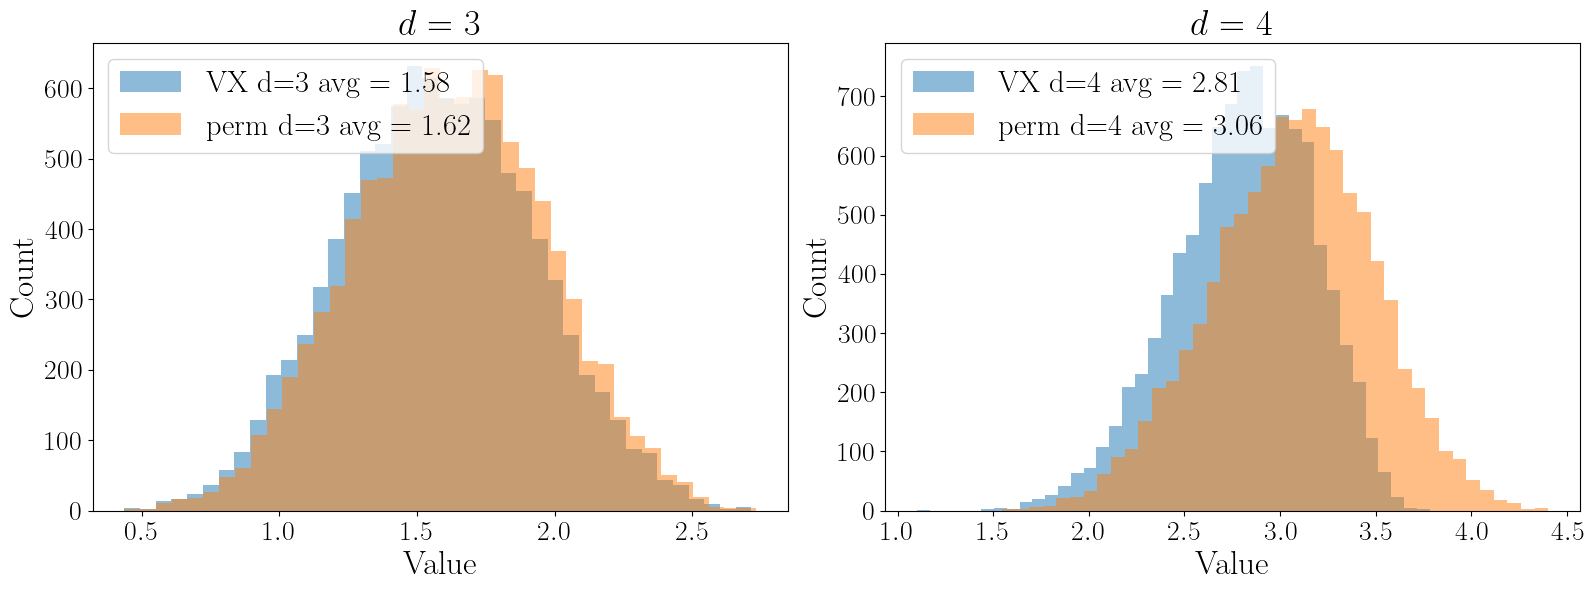

In [128]:
import matplotlib.pyplot as plt
import math
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True
vx_dict = {d: vals for d, vals in decomps_VX}
perm_dict = {d: vals for d, vals in decomps_perm}

ds = sorted(set(vx_dict.keys()) & set(perm_dict.keys()))
n = len(ds)

cols = min(3, n)
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows))

if n == 1:
    axes = [axes]
else:
    axes = axes.ravel()

for i, d in enumerate(ds):
    ax = axes[i]
    vals_vx = vx_dict[d]
    vals_perm = perm_dict[d]
    ax.hist(vals_vx, bins=40, alpha=0.5, label=f'VX d={d} avg = {np.mean(vals_vx):.2f}')
    ax.hist(vals_perm, bins=40, alpha=0.5, label=f'perm d={d } avg = {np.mean(vals_perm):.2f}')
    ax.set_title(f'$d$ = {d}', fontsize=26)
    ax.set_xlabel('Value', fontsize=24)
    ax.set_ylabel('Count', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(fontsize=22)

for j in range(len(ds), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [87]:
print(decomps_perm)

[(3, [1.4892858693205384, 1.2787610881797147, 1.4353370181395584, 2.235127473029931, 1.2370254579899351, 1.520907908955858, 0.8369048101159768, 1.7446490001825874, 1.6185396611796605, 1.769380125785661, 1.6779614303379815, 2.1620291433284664, 1.4406220682833661, 1.9813837606020763, 1.2616282802454075, 2.1894443821105702, 0.8653750617847964, 1.0031769242621469, 1.9725891822280537, 1.4194655748812028, 0.9018725789176018, 1.5179248350125398, 1.8260852589111163, 1.441619865691691, 2.29507457264783, 2.0792879641445676, 1.5074868073459862, 1.6727148277136874, 1.624251506676499, 1.352207706552317, 2.3587787936918723, 1.912916362590351, 1.4228356964153321, 1.231162354130043, 1.6890333134529387, 1.3879963229094074, 0.823192105205975, 1.9166255300868644, 2.0420128245851963, 1.8521889563921128, 1.799763125186078, 1.1646493661581117, 1.2066383915023255, 1.9707031998707283, 2.1344149262051864, 1.2264839712392361, 1.7030033575902523, 1.7230198635584324, 1.8144017383102762, 1.6109179144749404, 1.5776